In [92]:
(require '[acausal.core :as a :refer [defmodel model q query identify]] :reload-all)

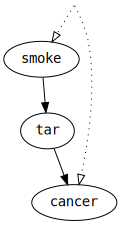

In [94]:
(defmodel pearl1995
    "Fig. 3 from Causal diagrams for empirical research (Pearl 1995)."
    {:smoke []
     :tar [:smoke]
     :cancer [:tar]}
    #{:smoke :cancer})

In [95]:
(identify
    pearl1995
    (query [:cancer] :do [:smoke]))

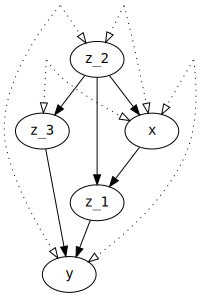

In [96]:
(defmodel shpitser2008
    "Figure 2g from (Shpitser + Pearl 2008)"
    {:x [:z_2]
     :z_1 [:x :z_2]
     :z_2 []
     :z_3 [:z_2]
     :y [:z_1 :z_3]}
    #{:x :z_2}
    #{:x :z_3}
    #{:x :y}
    #{:y :z_2})

In [100]:
(identify
    shpitser2008
    (q [:y] :do [:x]))

In [98]:
(identify
    (model
        {:y [:x]
         :x []})
    (q [:y] :do [:x]))